In [ ]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(1, os.path.abspath(os.pardir))
import CONFIG

%reload_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import Image

import pandas as pd
import numpy as np
import cv2
import os, re

import torch

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [11]:
INPUT_DIR = CONFIG.CFG.DATA.BASE
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))

In [ ]:
def read_image_from_path(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def read_image_from_train_folder(image_id):
    path = os.path.join(INPUT_DIR, "train", f"{image_id}.jpg")
    return read_image_from_path(path)

In [ ]:
sample_image_id = "b6ab77fd7"
plt.imshow(read_image_from_train_folder(sample_image_id))
_ = plt.title(sample_image_id)

In [10]:
def parse_bbox_text(string_input):
    input_without_brackets = re.sub("\[|\]", "", string_input)
    input_as_list = np.array(input_without_brackets.split(","))
    return input_as_list.astype(np.float)

def xywh_to_x1y1x2y2(x,y,w,h):
    return np.array([x, y, x+w, y+h])

In [12]:
bbox_series = train_df.bbox.apply(parse_bbox_text)

xywh_df = pd.DataFrame(bbox_series.to_list(), columns=["x", "y", "w", "h"])

x2_df = pd.DataFrame(xywh_df.x + xywh_df.w, columns=["x2"])
y2_df = pd.DataFrame(xywh_df.y + xywh_df.h, columns=["y2"])

train_df = train_df.join([xywh_df, x2_df, y2_df])
train_df.head()

,image_id,width,height,bbox,source,x,y,w,h,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [14]:
def draw_boxes_on_image(boxes, image, color=(255,0,0)):
    for box in boxes:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 3
        )
    return image

Text(0.5, 1.0, '4341d37a9')

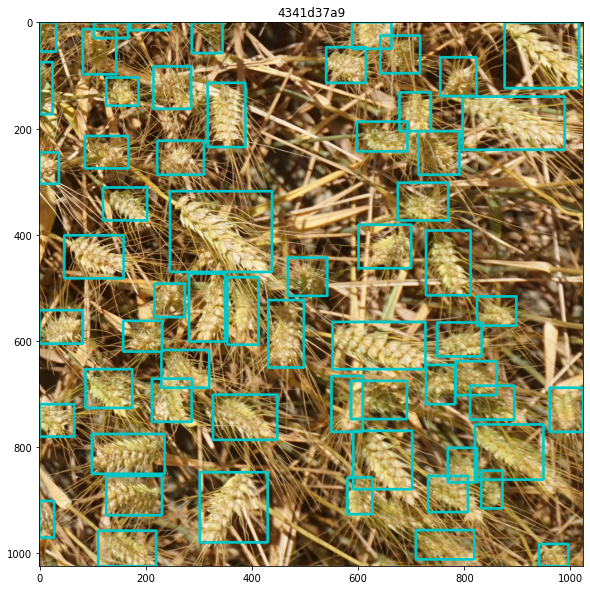

In [17]:
sample_image_id = train_df.image_id.sample().item()
sample_image = read_image_from_train_folder(sample_image_id)
sample_bounding_boxes = train_df[train_df.image_id == sample_image_id][["x", "y", "x2", "y2"]]

plt.imshow(draw_boxes_on_image(sample_bounding_boxes.to_numpy(), sample_image, color=(0, 200, 200)))
plt.title(sample_image_id)

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [19]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [21]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=2)

model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)